In [2]:
## Let's use this notebook to prepare the data for training in our GAN network

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
import glob

import tensorflow as tf

In [2]:
tf.__version__

'2.0.0-beta1'

In [3]:
labels = pd.read_csv('../data/list_attr_celeba.csv')
list(labels)

['image_id',
 '5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Blurry',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'Narrow_Eyes',
 'No_Beard',
 'Oval_Face',
 'Pale_Skin',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Straight_Hair',
 'Wavy_Hair',
 'Wearing_Earrings',
 'Wearing_Hat',
 'Wearing_Lipstick',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'Young']

In [4]:
## Let's separate the data into male and female for training
col = labels.columns.get_loc("Male")

classes = labels["Male"]
print("First 10 labels indices: ", classes[:10])

# Adjust classes to 0 and 1
classes = [x if x != -1 else 0 for x in classes]
print("First 10 labels indices: ", classes[:10])

First 10 labels indices:  0   -1
1   -1
2    1
3   -1
4   -1
5   -1
6    1
7    1
8   -1
9   -1
Name: Male, dtype: int64
First 10 labels indices:  [0, 0, 1, 0, 0, 0, 1, 1, 0, 0]


In [20]:
def load_image(path):
    img_raw = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    img = tf.image.resize(img,  size=(218, 218))
    img /= 255.0  # normalize 

    return img

In [ ]:

onlyfiles = [join("/home/alex/Desktop/Projects/tf/celeba/data/img/",f) for f in listdir("../data/img/") if isfile(join("../data/img/", f))]
image_count = len(onlyfiles)
paths_ds = tf.data.Dataset.from_tensor_slices(onlyfiles)
image_ds = paths_ds.map(load_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
image_ds

label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(classes, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

In [ ]:
# Now we need to get the labels
ds = tf.data.Dataset.from_tensor_slices((onlyfiles, classes))
# The tuples are unpacked into the positional arguments of the mapped function 
def load_and_preprocess_from_path_label(path, label):
  return load_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

In [ ]:
BATCH_SIZE = 256

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
#ds = ds.repeat()
ds = ds.batch(1)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
#ds = ds.prefetch(60000)
ds

In [ ]:
##### MODEL ########

In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [6]:
## Generator ##
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 56, 56, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 112, 112, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 224, 224, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 224, 224, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 224, 224, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 224, 224, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32,(3, 3), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 224, 224, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(16,(3,3), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 224, 224, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(3, (7, 7), strides=(1, 1), padding='valid', use_bias=False))
    assert(model.output_shape == (None, 218, 218, 3))

    return model


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       294912    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 128)       0

W0627 20:43:53.173077 139795756398400 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


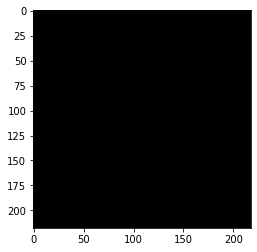

In [7]:
generator = make_generator_model()
generator.summary()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, :])

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same', 
                                        input_shape=[218, 218, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling2D((2,2),strides=(2,2)))
    
    model.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling2D((2,2),strides=(2,2)))
    model.add(layers.Dropout(0.3))
              
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling2D((2,2),strides=(2,2)))
    
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling2D((2,2),strides=(2,2)))
    
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling2D((2,2),strides=(2,2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling2D((2,2),strides=(2,2)))


    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [9]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 218, 218, 16)      448       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 218, 218, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 109, 109, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 54, 54, 32)       

In [10]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [14]:
checkpoint_dir = '.   training/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [15]:
EPOCHS =400
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [16]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [17]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [18]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.subplots(4,4,figsize=(20,20))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [21]:
onlyfiles = [join("/home/alex/Desktop/Projects/Summer_2019/tf/celeba/data/img/",f) for f in listdir("../data/img/") if isfile(join("../data/img/", f))]
i = 0
num_imgs = 5000
imgs = np.empty([num_imgs,218,218,3], dtype=np.float32)
while (i < num_imgs):
    img = load_image(onlyfiles[i]) 
    imgs[i] = img
    
    i += 1

BUFFER_SIZE = num_imgs
BATCH_SIZE = 2
train_dataset = tf.data.Dataset.from_tensor_slices(imgs).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
%%time 
train(train_dataset, EPOCHS)

###### %%time

train(train_dataset, EPOCHS)